In [57]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import main as ql
reload(ql)

plt.style.use('input/qulib.mplstyle')

# Bond option pricing

In [152]:
valuation_time = 0.0
short_rate = 0.01
curve = ql.FlatCurve(short_rate)
mean_rev = 0.1
local_vol = 0.01
exercise_time = 1.0
process = ql.VasicekProcess(curve=curve, mean_rev=mean_rev, local_vol=local_vol)

x_grid_stddevs = 5
y_grid_stddevs = 5
x_grid_center = 0.5 * local_vol**2 * exercise_time**2
y_grid_center = local_vol ** 2 * exercise_time
x_grid_stddev = local_vol * np.sqrt(exercise_time)
y_grid_stddev = 1e-4
x_freq = 3
y_freq = 3

mesh = ql.UniformMesh2D(x_grid_stddevs, y_grid_stddevs,
                       x_grid_center, y_grid_center,
                       x_grid_stddev, y_grid_stddev,
                       x_freq, y_freq)

t_step = 0.1
bond_expiry = 2.0
strike = 0.98
product = ql.ZCBCall(process, strike, exercise_time, bond_expiry)
times = np.arange(valuation_time,  exercise_time, t_step)

operator = ql.CheyetteOperator(process, mesh)
stepping_method = ql.PeacemanRachford(operator)
pde_engine = ql.CheyettePDEEngine(valuation_time, t_step, exercise_time, product, stepping_method)
analytic_engine = ql.CheyetteAnalyticEngine(valuation_time, product)

notional = 10000.0

## FDM Convergence

In [84]:
pv_analytic = analytic_engine.price()['PV']*notional

x_freqs = np.arange(10, 101, 10)
y_freq = 3
pvs_pde = []
for this_x_freq in x_freqs:
    operator = ql.CheyetteOperator(process, mesh)
    stepping_method = ql.PeacemanRachford(operator)
    mesh = ql.UniformMesh2D(x_grid_stddevs, y_grid_stddevs,
                       x_grid_center, y_grid_center,
                       x_grid_stddev, y_grid_stddev,
                       this_x_freq, y_freq)
    pde_engine = ql.CheyettePDEEngine(valuation_time, t_step, exercise_time, product, stepping_method)
    pvs_pde += [pde_engine.price()['PV']*notional]


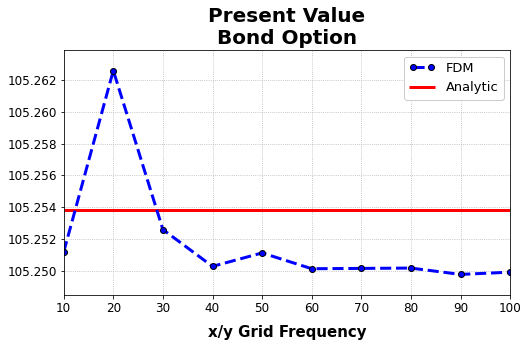

In [116]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(x_freqs, pvs_pde, label='FDM')
ax.set_xlabel('x/y Grid Frequency')
ax.set_title('Present Value\nBond Option')
ax.hlines(pv_analytic, x_freqs[0], x_freqs[-1], color='r', label='Analytic')
ax.legend()

# Curve Bumps

In [106]:
short_rates = np.arange(-0.05, 0.0501, 0.01)
pvs_curve_pde = []
pvs_curve_analytic = []
for r in short_rates:
    this_curve = ql.FlatCurve(r)
    this_process = ql.VasicekProcess(curve=this_curve, mean_rev=mean_rev, local_vol=local_vol)
    product = ql.ZCBCall(this_process, strike, exercise_time, bond_expiry)
    pde_engine = ql.CheyettePDEEngine(valuation_time, t_step, exercise_time, product, stepping_method)
    analytic_engine = ql.CheyetteAnalyticEngine(valuation_time, product)
    pvs_curve_pde += [pde_engine.price()['PV']*notional]
    pvs_curve_analytic += [analytic_engine.price()['PV']*notional]

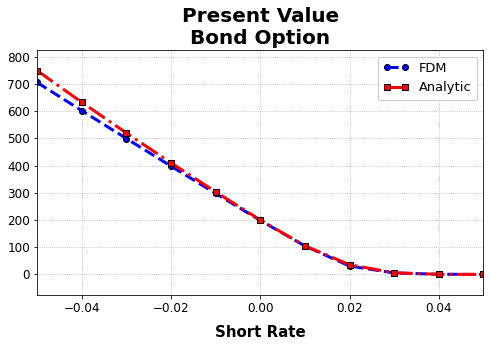

In [107]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(short_rates, pvs_curve_pde, label='FDM')
ax.plot(short_rates, pvs_curve_analytic, label='Analytic')
ax.set_xlabel('Short Rate')
ax.set_title('Present Value\nBond Option')
ax.legend()

# Volatility Bumps

In [153]:
mults = np.arange(-0.9, 2.1, 0.1)
pvs_vols_pde = []
pvs_vols_analytic = []
for mult in mults:
    this_local_vol = mult * local_vol
    this_process = ql.VasicekProcess(curve=curve, mean_rev=mean_rev, local_vol=this_local_vol)
    this_product = ql.ZCBCall(this_process, strike, exercise_time, bond_expiry)
    this_operator = ql.CheyetteOperator(this_process, mesh)
    this_stepping_method = ql.PeacemanRachford(this_operator)
    pde_engine = ql.CheyettePDEEngine(valuation_time, t_step, exercise_time, this_product, this_stepping_method)
    analytic_engine = ql.CheyetteAnalyticEngine(valuation_time, this_product)
    pvs_vols_pde += [pde_engine.price()['PV']*notional]
    pvs_vols_analytic += [analytic_engine.price()['PV']*notional]

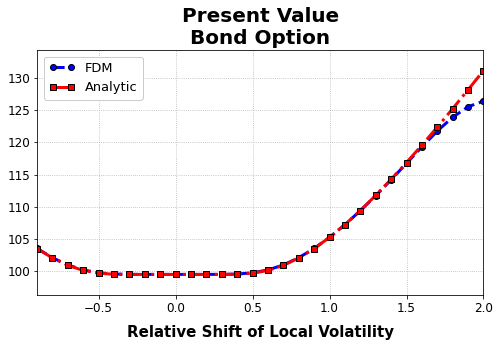

In [154]:
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot()
ax.plot(mults, pvs_vols_pde, label='FDM')
ax.plot(mults, pvs_vols_analytic, label='Analytic')
ax.set_xlabel('Relative Shift of Local Volatility')
ax.set_title('Present Value\nBond Option')
ax.legend()